In [1]:
#Imports
#Imports
import numpy as np
import pandas as pd
import seaborn as sns
import ast, json
import math
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
from statsmodels.stats import weightstats as stests
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import tree
from yellowbrick.regressor import ResidualsPlot
%matplotlib inline

In [2]:
#Useful methods
def get_elems_list(row, cols):
    elem_comb = {}
    elem_list = []
    i = 0
    for a in row:
        if not math.isnan(a):
            elem_list.append(cols[i])
        i+=1
    elem_comb['elements'] = elem_list
    return elem_comb

def get_data_rep(df):
    elements = get_elements(df)
    ecols = elements.columns
    data = df.drop(columns = ecols)
    e = pd.DataFrame()
    for i in range (0, len(elements)):
        e =e.append(get_elems_list(elements.loc[i], ecols), ignore_index=True)
    print(e)
    data['elements'] = e['elements']
    return data

def get_oth_props(df):
    elements = get_elements(df)
    ecols = elements.columns
    data = df.drop(columns = ecols)
    return data
def get_chi_corrs(df, func, ind):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            try:
                a  = []
                a.append(r)
                a.append(c)
                pvalues[r][c] = round(func(df[a])[ind], 4)
            except:
                print('err here')
    return pvalues

def run_on_df(df, f):
    a = pd.DataFrame()
    for c in df.columns:
        a[c] = f(df[c],0)
    return a

def get_heatmap(df):
    return df.style.background_gradient(cmap='magma') 

def get_corrs(df, func, ind):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(func(df[r], df[c])[ind], 4)

    return pvalues

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

def notnulls(data, col):
    return data[data[col].notnull()][col]

def get_counts_df(data):
    return pd.DataFrame(data.count()).transpose()

def numerify_df(data):
    for c in data.columns:
        try:
            data[c] = data[c].astype(float)
        except:
            print(c)
    return data

def drop_txt_rows(data):
    for col in data.columns:
        if data[col].dtype ==object:
            data = data.drop(col, axis=1)  
    data = data.fillna(0)
    return data

def get_elements(df):
    new_cols = []
    for c in df.columns:
        if len(c)<3:
            new_cols.append(c)
            
    return df[new_cols]

def get_pwr_corrs(df, func):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            if r==c:
                pvalues[r][c]=0
            else:
                pvalues[r][c] = round(np.mean(get_power(df, r, c, func)[0]), 4)

    return pvalues
            

In [3]:
df = pd.read_csv("final_numeric_data.csv").drop(columns = {'Unnamed: 0'})
columns = list(df.columns)
elems = get_elements(df)
elems = numerify_df(elems).astype(float).to_numpy()
elems[elems==0] = np.nan
df = numerify_df(df).astype(float).to_numpy()
df[df==0] = np.nan

/home/prasann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
def get_model_err(df,prop, model):
    tmp = np.concatenate([elems, df[:,columns.index(prop)].reshape(3255,1)], axis=1)
    tmp = np.nan_to_num(tmp)
    #tmp[tmp==0] = np.nan
    #tmp = tmp[pd.notnull(tmp[:,-1])]
    y = tmp[:,-1]
    X = np.nan_to_num(tmp)
    X = X[:,:-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
    lin_reg = model
    lin_reg.fit(X_train, y_train)
    pred = lin_reg.predict(X_test)
    err = mean_squared_error(y_test, pred)
    return err

def get_model_residual(df,prop, model):
    tmp = np.concatenate([elems, df[:,columns.index(prop)].reshape(3255,1)], axis=1)
    tmp = np.nan_to_num(tmp)
    #tmp[tmp==0] = np.nan
    #tmp = tmp[pd.notnull(tmp[:,-1])]
    y = tmp[:,-1]
    X = np.nan_to_num(tmp)
    X = X[:,:-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
    #Trying data transformation
    X_train = X_train+0.0000000000000001
    X_test = X_test+0.0000000000000001
    X_train = np.power(X_train,-.2)
    X_test = np.power(X_test,-.2)
    lin_reg = ResidualsPlot(model)
    lin_reg.fit(X_train, y_train)
    lin_reg.score(X_test, y_test)
    return lin_reg

In [5]:
get_model_err(df, "Category")

TypeError: get_model_err() missing 1 required positional argument: 'model'

In [6]:
print(df[:,columns.index(columns[2])].reshape(3255,1))

[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]


In [5]:
def try_model(model):
    a = []
    for i in range (0,16):
        err = get_model_err(df, columns[i],model)
        a.append(err)
    i = 0
    for c in a:
        if c<1:
            print(columns[i] +" "+str(c))
        i+=1
    return a
        
def get_res_plots(model):
    a = []
    for i in range (0,16):
        err = get_model_residual(df, columns[i],model)
        print(columns[i])
        err.show()
        a.append(err)

Category


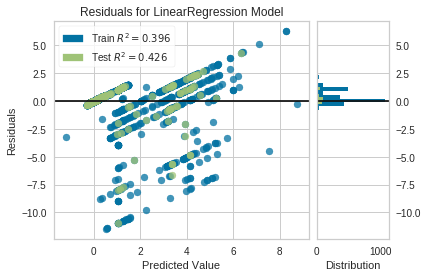

Charpy


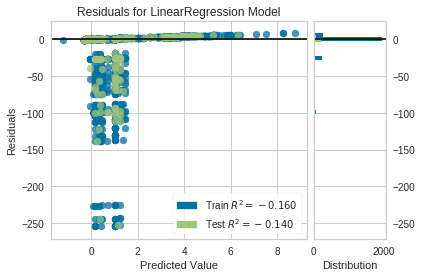

DIN_W


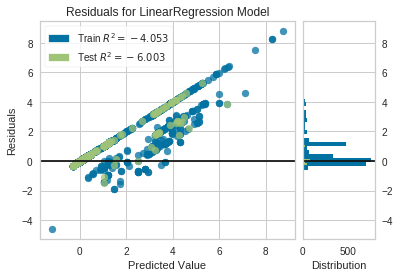

Elongation


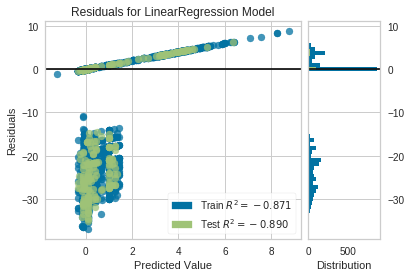

HT_Temp


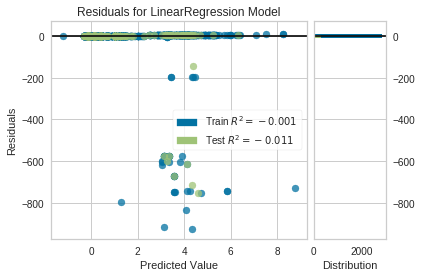

Hardness_Scale


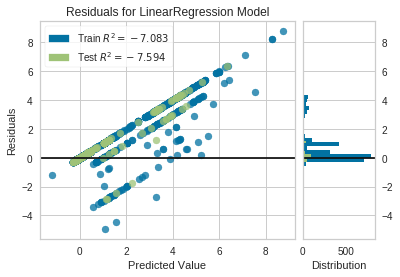

IE-20


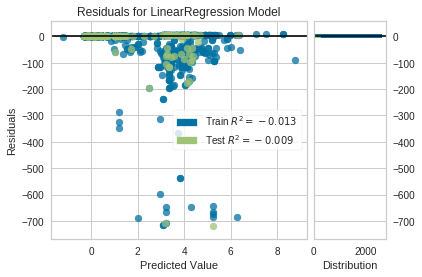

Manual metal arc_Heat input


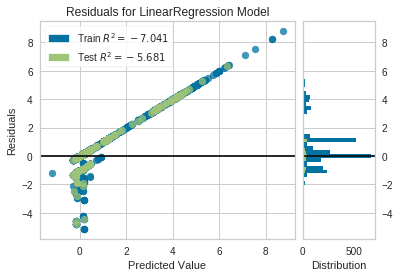

Manual metal arc_Interpass temperature


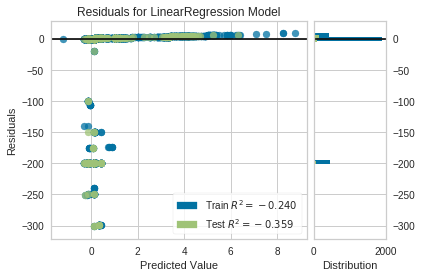

Redry_Time


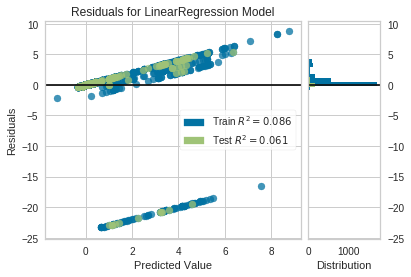

Reduction of area


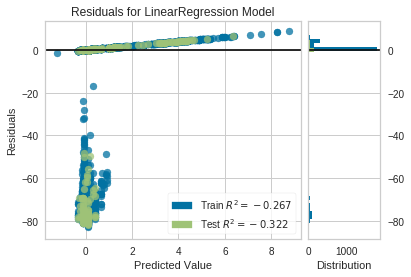

Rp0


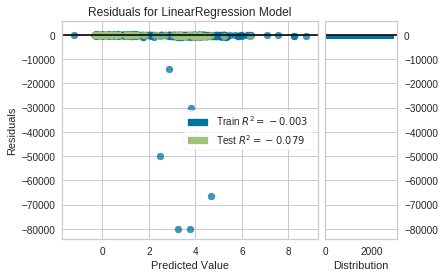

Tensile


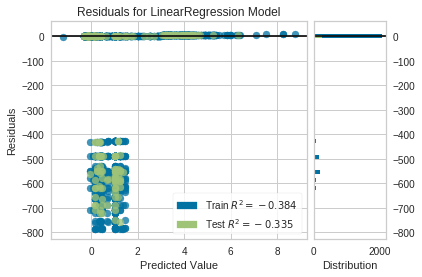

Ultimate tensile strength


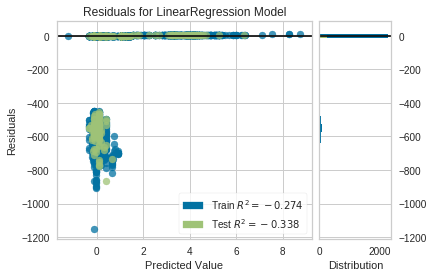

Yield


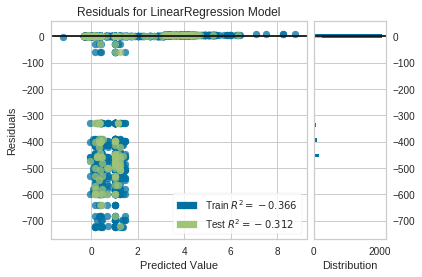

Yield strength


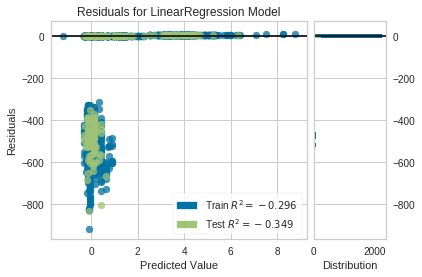

In [6]:
get_res_plots(linear_model.LinearRegression())


In [6]:
from sklearn import svm

In [8]:
try_model(ensemble.RandomForestRegressor())

/home/prasann/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


DIN_W 0.07940102349318152
Hardness_Scale 0.09382317098107486
Manual metal arc_Heat input 0.3614147521435051


In [14]:
try_model(linear_model.LinearRegression())

DIN_W 0.10987119944866962
Hardness_Scale 0.2003362740479698
Manual metal arc_Heat input 0.3394961737066675


[2.132195374077773,
 655.3102002286063,
 0.10987119944866962,
 123.71162560860404,
 7162.879875958097,
 0.2003362740479698,
 1444.3851248262138,
 0.3394961737066675,
 6217.441326548177,
 16.0183505050794,
 773.2375748458685,
 167358.88545045583,
 12630.823746494882,
 48771.605125579765,
 11096.978584856271,
 37378.71159582275]

In [ ]:
t = try_model(svm.SVR(kernel = 'linear', C=1000))

In [ ]:
print(t)

In [7]:
import pandas as pd
from xgboost import XGBRFRegressor
from sklearn.metrics import accuracy_score

In [15]:
try_model(XGBRegressor())

[21:08:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:08:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:08:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:08:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:08:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:08:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:08:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:08:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[1.669486962896262,
 645.1753925871617,
 0.10312447449675048,
 103.18961459947872,
 5484.029874187485,
 0.09797263577499045,
 967.1274838775004,
 0.263335535060129,
 4771.860175168826,
 9.09314420400554,
 720.1518897794107,
 564778.1503883341,
 5913.003492349578,
 43391.39032373773,
 6480.6171853828355,
 32672.351943018894]

In [7]:
def try_mod(model):
    a = []
    for i in range (0,16):
        err = get_model_err(df, columns[i],model)
        a.append(err)
    i = 0
    for c in a:
        if c<1:
            print(columns[i] +" "+str(c))
        i+=1
    return a

In [20]:
#Hyperopt sample code

In [8]:
from hyperopt import hp
import numpy as np
from sklearn.metrics import mean_squared_error


# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
    'silent':True,
}
xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# LightGBM parameters
lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}
lgb_fit_params = {
    'eval_metric': 'l2',
    'early_stopping_rounds': 10,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# CatBoost parameters
ctb_reg_params = {
    'learning_rate':     hp.choice('learning_rate',     np.arange(0.05, 0.31, 0.05)),
    'max_depth':         hp.choice('max_depth',         np.arange(5, 16, 1, dtype=int)),
    'colsample_bylevel': hp.choice('colsample_bylevel', np.arange(0.3, 0.8, 0.1)),
    'n_estimators':      100,
    'eval_metric':       'RMSE',
}
ctb_fit_params = {
    'early_stopping_rounds': 10,
    'verbose': False
}
ctb_para = dict()
ctb_para['reg_params'] = ctb_reg_params
ctb_para['fit_params'] = ctb_fit_params
ctb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [9]:
import lightgbm as lgb
import xgboost as xgb
import catboost as ctb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials


class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def ctb_reg(self, para):
        reg = ctb.CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [10]:
def get_model_hpt_err(df,prop):
    tmp = np.concatenate([elems, df[:,columns.index(prop)].reshape(3255,1)], axis=1)
    tmp = np.nan_to_num(tmp)
    #tmp[tmp==0] = np.nan
    #tmp = tmp[pd.notnull(tmp[:,-1])]
    y = tmp[:,-1]
    X = np.nan_to_num(tmp)
    X = X[:,:-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
    
    obj = HPOpt(X_train, X_test, y_train, y_test)
    
    #xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)
    lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)
    #ctb_opt = obj.process(fn_name='ctb_reg', space=ctb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

    #lin_reg = model
    #lin_reg.fit(X_train, y_train)
    #pred = xgb_opt[0].predict(X_test)
    #err = mean_squared_error(y_test, pred)
    #return err
    print(lgb_opt)
def try_hpt_model():
    a = []
    for i in range (0,16):
        get_model_hpt_err(df, columns[i])
        #a.append(err)
    i = 0
    for c in a:
        if c<1:
            print(columns[i] +" "+str(c))
        i+=1
    return a

In [11]:
print(try_hpt_model())
"""
best models
[
1.669486962896262,
 645.1753925871617,
 0.10312447449675048,
 103.18961459947872,
 5484.029874187485,
 0.09797263577499045,
 967.1274838775004,
 0.263335535060129,
 4771.860175168826,
 9.09314420400554,
 720.1518897794107,
 564778.1503883341,
 5913.003492349578,
 43391.39032373773,
 6480.6171853828355,
 32672.351943018894]
"""

 48%|████▊     | 48/100 [00:02<00:03, 16.10trial/s, best loss: 1.1662109384405202]


KeyboardInterrupt: 

In [41]:
def tup():
    return 10, 5

a = tup()[0]

In [42]:
print(a)

10


In [18]:
get_model_err(df, 'Category', xgb.XGBRegressor(colsample_bytree=2, learning_rate=5, max_depth=7, min_child_weight=2, subsample=0.809545173010251,n_estimators=100))

[20:57:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBoostError: value 2 for Parameter colsample_bytree exceed bound [0,1]

In [11]:
import sklearn.gaussian_process as gp
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
get_model_err(df, "Category",model)

2.9057233601445844